In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from utils import windowed_dataset, build_basic_lstm,split_train_test,split_train_test_val

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import datetime
from glob import glob

import numpy as np
#import mlflow
#mlflow.set_tracking_uri("http://localhost:5001")
#tracking_uri = mlflow.get_tracking_uri()
#print("Current tracking uri: {}".format(tracking_uri))
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]
plt.style.use('fivethirtyeight')
today=datetime.date.today().strftime("%Y%m%d")

In [2]:
tf.test.is_built_with_cuda(), tf.test.gpu_device_name()

(True, '/device:GPU:0')

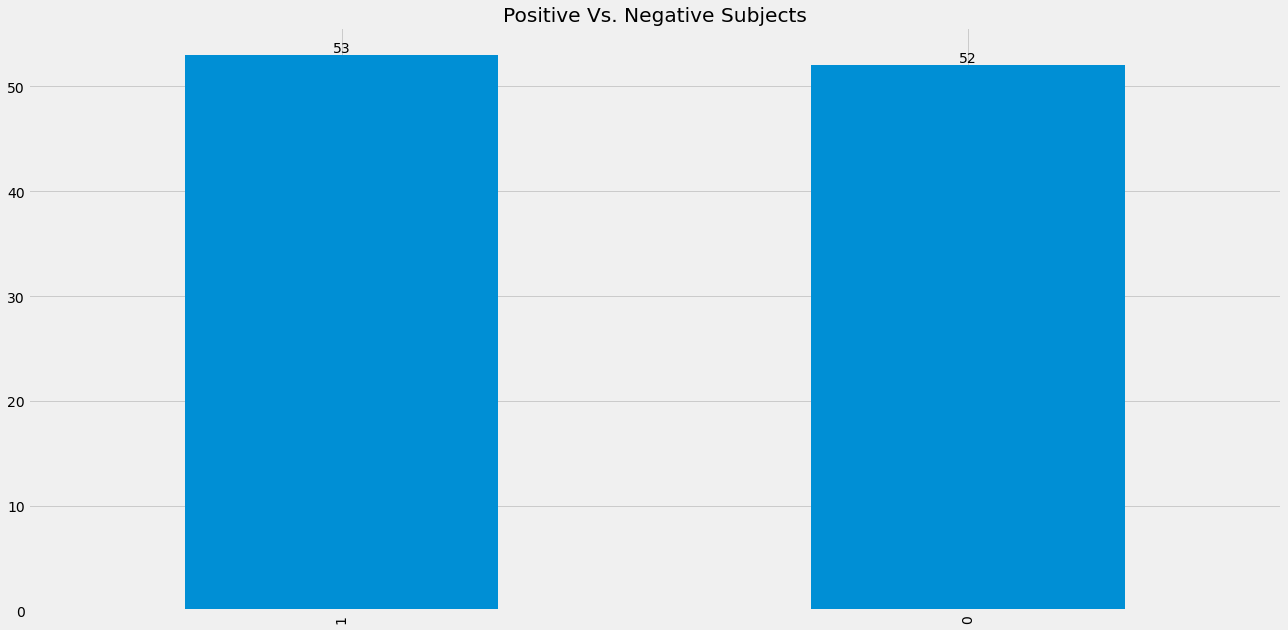

In [5]:
levels = pd.read_csv('/data/elekin/data/results/fmri/preproc/cbl/cbl_levels_{}.csv'.format(20220908),index_col=0)
levels.sample(5)
labels = (levels.Level > 0).astype(np.int16)
ax = labels.value_counts().plot.bar(title='Positive Vs. Negative Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [4]:
files = glob('/data/elekin/data/results/fmri/preproc/cbl/*/cbl_extracted_ts_{}.csv'.format(20220908))
data = []
for file in files:
    df = pd.read_csv(file, header=None)
    data.append(df.values)
features = np.array(data)
features.shape

(105, 158, 28)

In [7]:
x=features.astype('float32')
y=labels.values.astype('int8').reshape(-1,1)
x.shape, y.shape

((105, 158, 28), (105, 1))

Window function is applied to Dataset objects. Same windows lenghts for each time series corresponding to each subject are built asigning the rigth label. Then they are included in same Dataset object.

In [9]:
#windowing parameters
num_features = x.shape[1]
window_size = int(num_features/5 + 1)
shuffle_buffer = num_features
batch_size = 1

In [10]:
features=tf.data.Dataset.from_tensor_slices(x)
labels=(y)

In [11]:
#series, window_size, batch_size,label
for i,features in enumerate(x):
    new = windowed_dataset(features,window_size,batch_size,labels[i])
    if i>0:
        dataset = tf.data.Dataset.concatenate(dataset,new)
    else:
        dataset = new
        
dataset.cache()
dataset.element_spec

(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(1,), dtype=tf.int8, name=None))

(32, 28)
(32, 28)
(32, 28)
(32, 28)


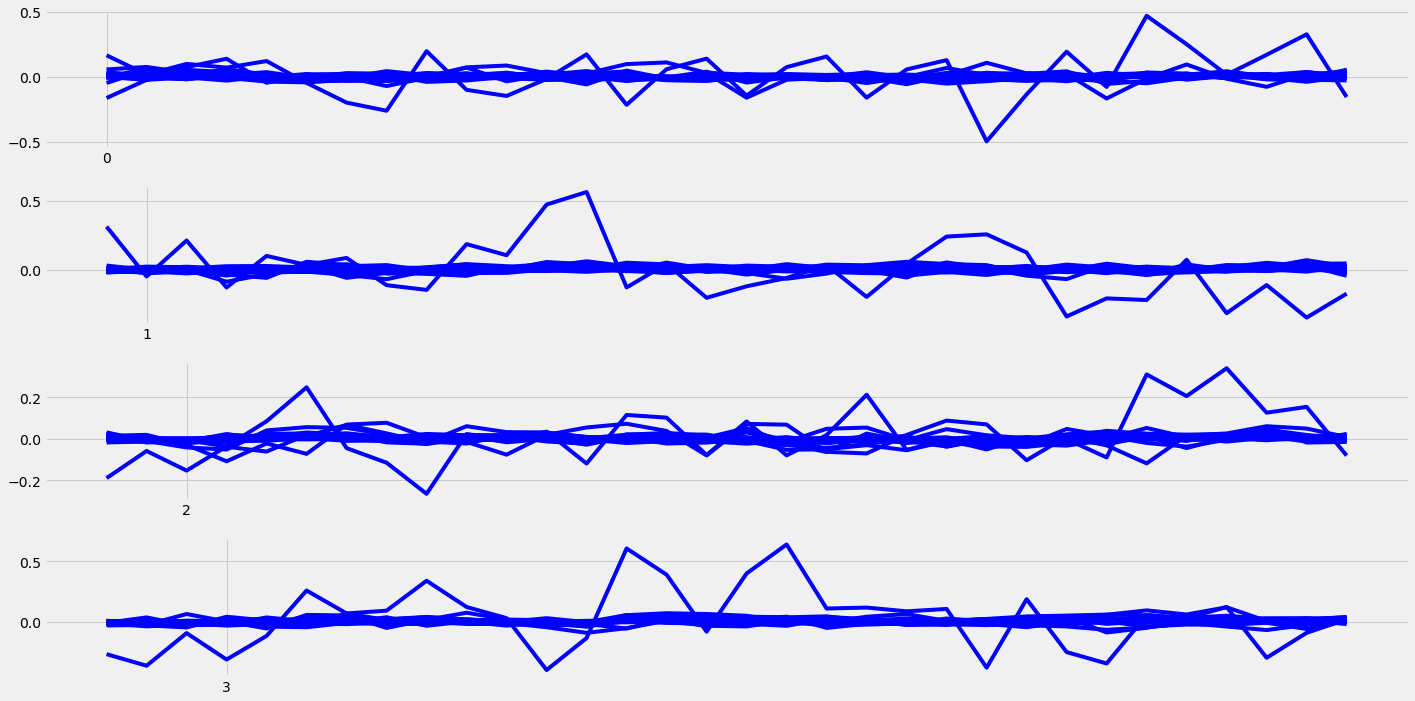

In [23]:
fig, axes = plt.subplots(4,1)
fig.tight_layout()
i=0
for (feat,label),ax in zip(dataset.shuffle(1000).take(4),axes):
    ax.plot(feat.numpy(), c='blue')
    ax.set_xticks(range(i,window_size,100))
    i+=1
    print(feat.numpy().shape)

We can apply filters to a Dataset object

In [13]:
positive_filter=lambda x,y: tf.equal(y, 1)[0]
negative_filter=lambda x,y: tf.equal(y, 0)[0]
positive_samples=dataset.filter(positive_filter).cache()
negative_samples=dataset.filter(negative_filter).cache()

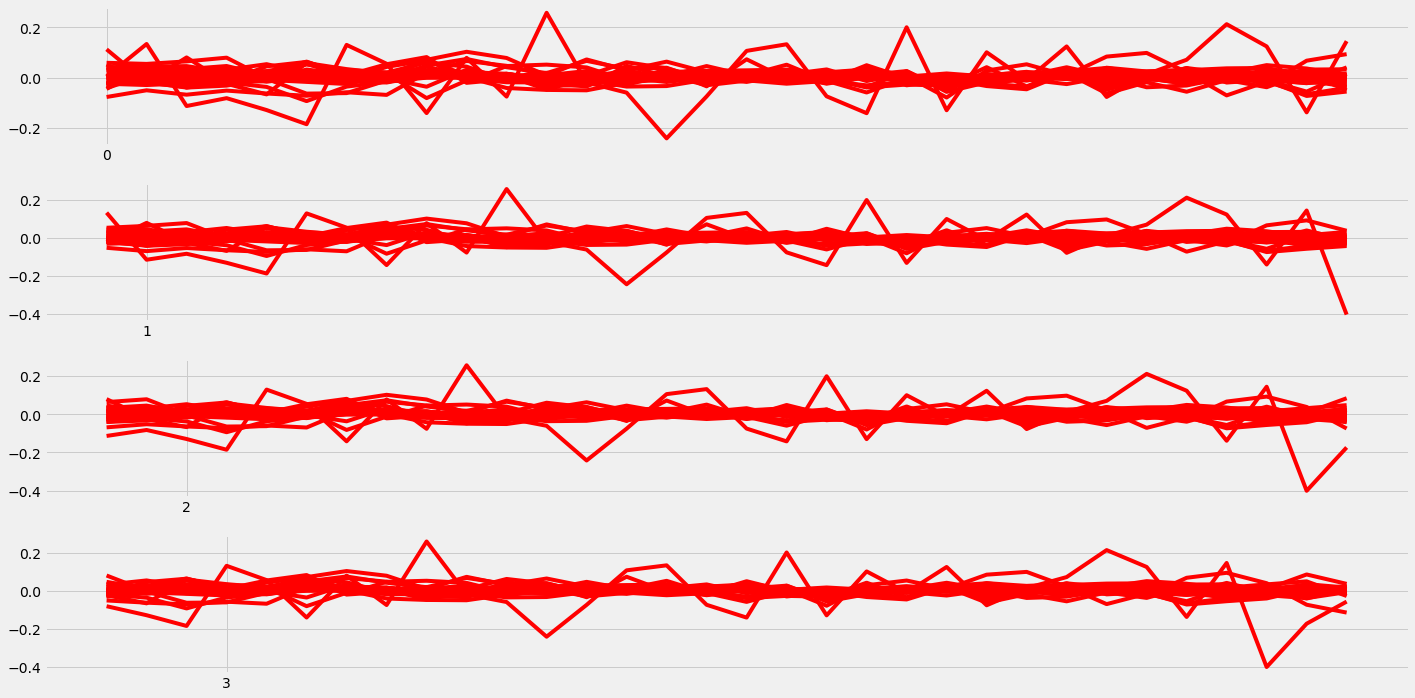

In [16]:
fig, axes = plt.subplots(4,1)
fig.tight_layout()
i=0
for (feat,label),ax in zip(positive_samples.take(4), axes):
    ax.plot(feat.numpy(), c='red')
    ax.set_xticks(range(i,window_size,100))
    i+=1

It is possible to access just to one element using python iterator. In the example bellow it is showed also how to shuffle the dataset and batch together some examples into minibatches:

In [31]:
# iterator = iter(positive_samples.shuffle(shuffle_buffer).cache().batch(batch_size).cache())
# n_iterator = iter(negative_samples.shuffle(shuffle_buffer).cache().batch(batch_size).cache())
iterator = iter(positive_samples.batch(batch_size).cache())
n_iterator = iter(negative_samples.batch(batch_size).cache())

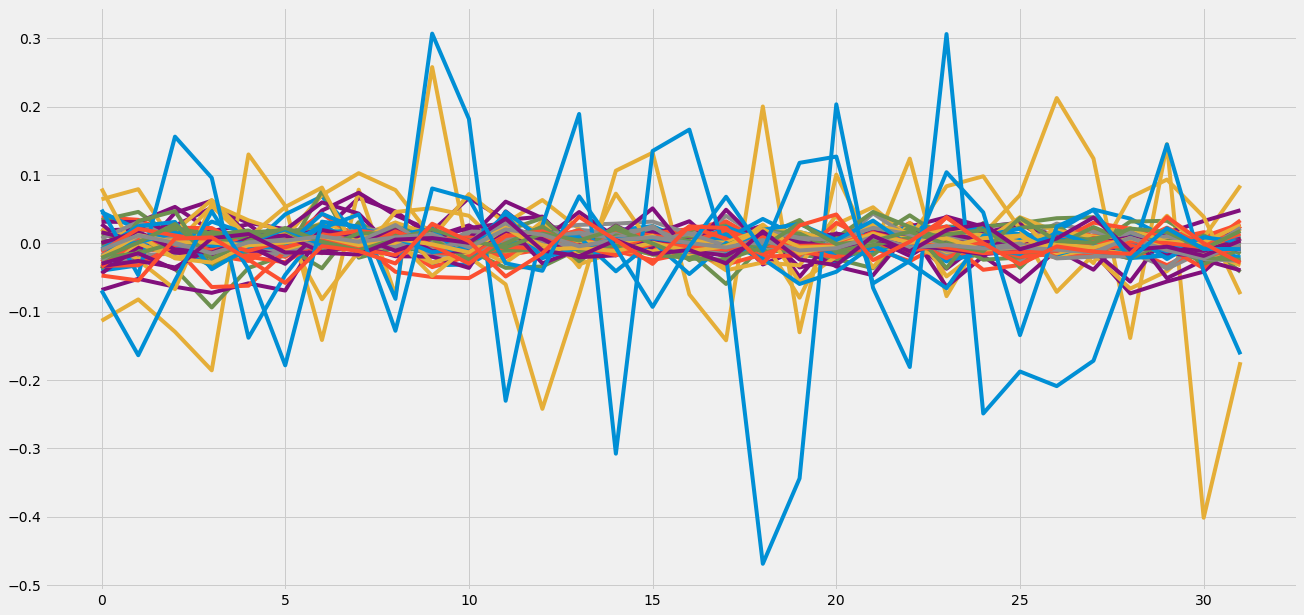

In [34]:
first = iterator.next()
n_first = n_iterator.next()

plt.plot(first[0].numpy()[0])
_=plt.plot(n_first[0].numpy()[0])